In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout, BatchNormalization


/home/apanin/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
Using Theano backend.


# Searching for Higgs boson

discriminate two kinds of processes that possibly could be studied at the LHC.

<img  src="higgs_feynman.png"/>

## Data description

Dataset consists of 21 low-level features and 7 high-level features.
- low-level features are momenta: lepton momentum
- momenta and b-tags of 4 jets missing transverse momentum
- high-level features are invariant masses

feature named 'target' is present only in training. `1` corresponds to signal (Higgs) decay, `0` to background

Evaluation metric: __ROC AUC__

### Acknowledgment

Thanks to P. Baldi, P. Sadowski, and D. Whiteson for publishing original dataset.

<img  src="roc_vs_significance.png"/>
Baldi et al., 2014 Searching for Exotic Particles in High-Energy Physics with Deep Learning (http://arxiv.org/abs/1402.4735)

Dataset is hosted at https://archive.ics.uci.edu/ml/datasets/HIGGS


In [2]:
import os
import pandas as pd
def load_data(data_path="higgs-data", suffix=None):
    df = pd.read_csv(os.path.join(data_path,"HIGGS_1000000.csv"), header=None, index_col=None)
    df = df.astype(np.float32)
    y = df[0].values==1
    X = df[df.columns[1:]].values.astype("float32")
    return X, y

X, y = load_data("higgs-data")
n_features = X.shape[1]
N_EPOCH = 20 # theano.config.device == 'gpu'
HOLDOUT_SIZE = 500000
BATCH_SIZE = 2000

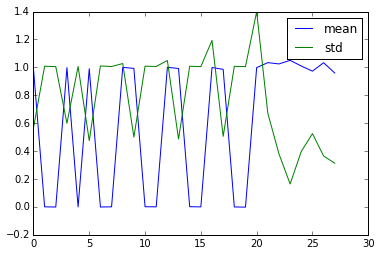

In [3]:
plt.plot(X.mean(0),label="mean")
plt.plot(X.std(0), label="std")
_ = plt.legend();

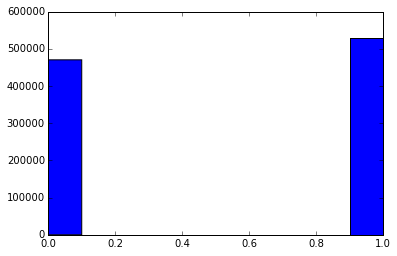

In [4]:
_ = plt.hist(y)

In [5]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=HOLDOUT_SIZE, random_state=42)

In [6]:
X_train

array([[ 0.58947229, -0.16173296,  0.33721739, ...,  3.89330411,
         3.33545494,  2.58757854],
       [ 0.94304585, -0.18218632,  0.85101897, ...,  0.758636  ,
         1.22592688,  1.08016479],
       [ 0.65535557, -1.21946299, -0.30652437, ...,  2.74427032,
         1.49601126,  1.17035723],
       ..., 
       [ 1.37787545, -1.61781621, -1.44010878, ...,  0.92217571,
         0.90575123,  1.07951367],
       [ 1.31620133, -0.95843947, -1.23813927, ...,  1.2260201 ,
         1.04802704,  0.89940441],
       [ 0.28549418, -1.88663161, -1.11218572, ...,  1.3549546 ,
         0.86062706,  0.73824358]], dtype=float32)

In [7]:
y_train

array([ True, False, False, ..., False, False, False], dtype=bool)

## Start from logistic regression

In [8]:
dims = X.shape[1]

def build_logistic_regression(dims):
    print(dims, 'dims')
    print("Building model...")
    model = Sequential()
    model.add(Dense(1, input_shape=(dims,), init='zero'))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    return model
model = build_logistic_regression(dims)

(28, 'dims')
Building model...


In [9]:
%%time
model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=5)
#from sklearn.metrics import roc_auc_score

#print ("train AUC:", roc_auc_score(y_train, model.predict(X_train)))


Epoch 1/5
500000/500000 [==============================] - 4s - loss: 0.6788     
Epoch 2/5
500000/500000 [==============================] - 4s - loss: 0.6639     
Epoch 3/5
500000/500000 [==============================] - 5s - loss: 0.6561     
Epoch 4/5
500000/500000 [==============================] - 4s - loss: 0.6517     
Epoch 5/5
500000/500000 [==============================] - 4s - loss: 0.6492     
CPU times: user 20.6 s, sys: 3.57 s, total: 24.2 s
Wall time: 24.5 s


In [10]:
from sklearn.metrics import roc_auc_score
print ("train AUC:", roc_auc_score(y_train, model.predict(X_train)))
print ("val AUC:", roc_auc_score(y_test, model.predict(X_test)))

('train AUC:', 0.6616958203896921)
('val AUC:', 0.66207023106054352)


## Callbacks

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument 

In [11]:
class AucHistories(keras.callbacks.Callback):
    def __init__(self, X_train=None, y_train=None):
        self.X_train = X_train
        self.y_train = y_train
        
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.train_aucs = []
        self.losses = []
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        if self.model.validation_data is not None:
            y_pred = self.model.predict(self.model.validation_data[0])
            self.aucs.append(roc_auc_score(self.model.validation_data[1], y_pred))
        if self.X_train is not None:
            y_pred = self.model.predict(self.X_train)
            self.train_aucs.append(roc_auc_score(self.y_train, y_pred))
        return

In [12]:
logistic_auc = AucHistories()
model = build_logistic_regression(dims)
model.reset_states()
logistic_history = model.fit(X_train, y_train, nb_epoch=N_EPOCH, batch_size=BATCH_SIZE, callbacks=[logistic_auc], validation_data=(X_test, y_test))

(28, 'dims')
Building model...
Train on 500000 samples, validate on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 35s - loss: 0.6790 - val_loss: 0.6696
Epoch 2/20
500000/500000 [==============================] - 41s - loss: 0.6642 - val_loss: 0.6593
Epoch 3/20
500000/500000 [==============================] - 32s - loss: 0.6561 - val_loss: 0.6534
Epoch 4/20
500000/500000 [==============================] - 40s - loss: 0.6516 - val_loss: 0.6501
Epoch 5/20
500000/500000 [==============================] - 35s - loss: 0.6491 - val_loss: 0.6484
Epoch 6/20
500000/500000 [==============================] - 40s - loss: 0.6476 - val_loss: 0.6471
Epoch 7/20
500000/500000 [==============================] - 39s - loss: 0.6465 - val_loss: 0.6462
Epoch 8/20
500000/500000 [==============================] - 37s - loss: 0.6457 - val_loss: 0.6455
Epoch 9/20
500000/500000 [==============================] - 42s - loss: 0.6451 - val_loss: 0.6449
Epoch 10/20
500000/500000 [========

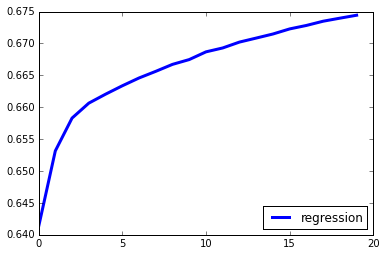

In [13]:
plt.plot(logistic_auc.aucs, label="regression", lw=3)
_ = plt.legend(loc="lower right")

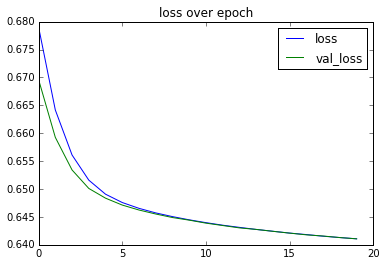

In [14]:
plt.plot(logistic_history.history['loss'], label="loss")
plt.plot(logistic_history.history['val_loss'], label="val_loss")
plt.legend()
_ = plt.title("loss over epoch")

## Basic Neural Network

with Adam optimization
(Kingma & Ba, 2014 Adam: A Method for Stochastic Optimization (http://arxiv.org/abs/1412.6980))

"... based on adaptive estimates of lower-order moments ..."

https://www.quora.com/Can-you-explain-basic-intuition-behind-ADAM-a-method-for-stochastic-optimization

In [15]:
def build_basic_NN(dims):
    model = Sequential()

    model = Sequential()
    #model.add(InputLayer(input_shape=(X.shape[1],)))

    #a fully-connected layer above input
    model.add(Dense(300,input_dim=dims, activation='tanh'))

    #a fully-connected layer above other layer
    model.add(Dense(300, activation='tanh'))

    #a fully-connected layer with sigmoid output - this layer will be interpreted as NN output
    model.add(Dense(1, activation='sigmoid'))

    #logloss, see https://www.kaggle.com/wiki/LogarithmicLoss
    loss = keras.objectives.binary_crossentropy

    # optimizer that will train the NN to minimize loss above. 
    # may or may not be suboptimal choice. See dir(keras.optimizers)
    optimizer = keras.optimizers.adam(lr=0.001)
    model.compile(loss=loss, optimizer=optimizer,
              metrics=[keras.metrics.binary_accuracy] #also monitor accuracy
             )
    return model


In [16]:
model = build_basic_NN(X.shape[1])

In [17]:
class AucHistory(keras.callbacks.Callback):
    def __init__(self, X_train=None, y_train=None):
        self.X_train = X_train
        self.y_train = y_train
        
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.train_aucs = []
        self.losses = []
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        if self.model.validation_data is not None:
            y_pred = self.model.predict(self.model.validation_data[0])
            self.aucs.append(roc_auc_score(self.model.validation_data[1], y_pred))
        if self.X_train is not None:
            y_pred = self.model.predict(self.X_train)
            self.train_aucs.append(roc_auc_score(self.y_train, y_pred))
        return

In [18]:
basic_NN_aucs = AucHistories()
basic_NN_histories = model.fit(X_train, y_train, nb_epoch=N_EPOCH, batch_size=BATCH_SIZE, 
          validation_data=[X_test,y_test], callbacks=[basic_NN_aucs])


Train on 500000 samples, validate on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 49s - loss: 0.6466 - binary_accuracy: 0.6200 - val_loss: 0.6369 - val_binary_accuracy: 0.6353
Epoch 2/20
500000/500000 [==============================] - 38s - loss: 0.6288 - binary_accuracy: 0.6471 - val_loss: 0.6235 - val_binary_accuracy: 0.6534
Epoch 3/20
500000/500000 [==============================] - 49s - loss: 0.6122 - binary_accuracy: 0.6650 - val_loss: 0.6013 - val_binary_accuracy: 0.6773
Epoch 4/20
500000/500000 [==============================] - 44s - loss: 0.5922 - binary_accuracy: 0.6828 - val_loss: 0.5838 - val_binary_accuracy: 0.6904
Epoch 5/20
500000/500000 [==============================] - 42s - loss: 0.5823 - binary_accuracy: 0.6911 - val_loss: 0.5772 - val_binary_accuracy: 0.6949
Epoch 6/20
500000/500000 [==============================] - 50s - loss: 0.5744 - binary_accuracy: 0.6969 - val_loss: 0.5684 - val_binary_accuracy: 0.7015
Epoch 7/20
500000/500000

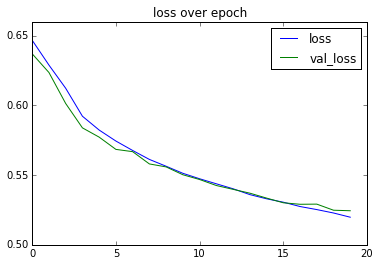

In [19]:
plt.plot(basic_NN_histories.history['loss'], label="loss")
plt.plot(basic_NN_histories.history['val_loss'], label="val_loss")
plt.legend()
_ = plt.title("loss over epoch")

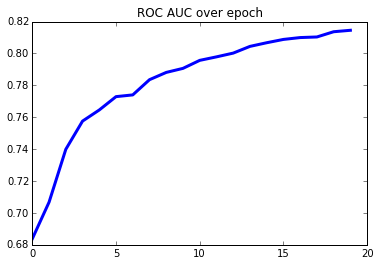

In [20]:
plt.plot(basic_NN_aucs.aucs, lw=3)
_ = plt.title("ROC AUC over epoch")

## So far so good ...

A few obvious ideas to improve performance:

- batch normalization
- dropout
- make it deeper


### Batch normalization

- Consider a neuron in any layer beyond first
- At each iteration we tune it's weights towards better loss function
- But we also tune it's inputs. Some of them become larger, some – smaller
- Now the neuron needs to be re-tuned for it's new inputs

Idea: _It's usually a good idea to normalize linear model inputs_
- We normalize activation of a hidden layer
(zero mean unit variance)
- Now all neurons have ~same output range

<small>Ioffe &amp; Szegedi, 2015 Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (http://arxiv.org/abs/1502.03167)</small>

## How to BatchNorm in Keras

```python
from keras.layers.normalization import BatchNormalization

BatchNormalization(epsilon=1e-06, mode=0, 
                   axis=-1, momentum=0.99, 
                   weights=None, beta_init='zero', 
                   gamma_init='one')
```

## Dropout



The **dropout layers** have the very specific function to *drop out* a random set of activations in that layers by setting them to zero in the forward pass. Simple as that. 

It allows to avoid *overfitting* but has to be used **only** at training time and **not** at test time.

<img  src="dropout.png"/>

Hinton et al., 2012 Improving neural networks by preventing co-adaptation of feature detectors (http://arxiv.org/abs/1207.0580)

In [ ]:
def build_model_dropout_batch(n_features=28,num_layers=1, size=100, lr=1e-3, keep_prob=1.0,nonlinearity='relu'):
    model = Sequential()
    model.add(InputLayer([n_features]))
    
    for i in range(num_layers): 
        model.add(Dense(size)) #fully-connected linear
        model.add(BatchNormalization()) #batchnorm
        model.add(Activation(nonlinearity)) #nonlinearity
        if keep_prob<1.0:
            model.add(Dropout(1.-keep_prob)) #dropout (if any)
    
    
    #a fully-connected layer with sigmoid output - this layer will be interpreted as NN output
    model.add(Dense(1, activation='sigmoid'))
    
    #logloss, see https://www.kaggle.com/wiki/LogarithmicLoss
    loss = keras.objectives.binary_crossentropy

    # optimizer that will train the NN to minimize loss above. 
    # may or may not be suboptimal choice. See dir(keras.optimizers)
    optimizer = keras.optimizers.adam(lr=lr)

    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[keras.metrics.binary_accuracy], #also monitor accuracy
                      
                 )
    
    return model

In [ ]:
%%time
model = build_model_dropout_batch(n_features=n_features,num_layers=6,size=600,keep_prob=0.9)
dropout_batch_aucs = AucHistories()
dropout_batch_histories = model.fit(X_train, y_train, nb_epoch=int(N_EPOCH*1.5), batch_size=BATCH_SIZE, 
          validation_data=[X_test,y_test], callbacks=[dropout_batch_aucs], verbose=0)

In [ ]:
plt.plot(dropout_batch_histories.history['loss'], label="loss")
plt.plot(dropout_batch_histories.history['val_loss'], label="val_loss")
plt.legend()
_ = plt.title("loss over epoch")

In [ ]:
plt.plot(dropout_batch_aucs.aucs, lw=3)
_ = plt.title("ROC AUC over epoch")

##  further steps
  - Increased learning rate (with batch normalization, on ImageNet authors were able to use 30x the original learning rate)
  - Decreased learning rate towards the end of the training - fine tuning
  - Averaging parameters of the models (between current and e.g. previous epoch or a few previous iterations) - this helps on image models
  - Averaging predictions - this almost always helps. If you optimize likelihood of some distributions, replacing predictions with an average of a few models is still an estimator but has typically lower variance
  - Reducing batch size and training for more time once we find good parameters (potentially also increasing dropout rate)
  - Or ... any tuning of the parameters - we didn't do almost any!
  - Different optimizer/params to train faster/more stable
  - Different nonlinearities for hidden layers
  - deeper networks